In [22]:
import numpy as np
from scipy.stats import uniform, bernoulli
import itertools
import matplotlib.pyplot as plt

In [23]:
class ErdosRenyiFJ:
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper):
        assert w_lower >= 0
        assert w_upper >= w_lower
        self.n = n
        self.weights = bernoulli.rvs(p, size=[n,n]) * uniform.rvs(loc=w_lower, scale=w_upper - w_lower, size=[n, n])
        # zero out the diagonal since w_{ii} is only used for internal opinions rather than expressed opinions
        for i in range(n):
            self.weights[i][i] = 0
        self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=n)
        self.expressed = self.internal.copy()

    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'

    def disagreement(self):
        disagreement = 0
        for i, j in itertools.product(range(self.n), range(self.n)):
            disagreement += abs(self.weights[i][j]) * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement

    def polarization(self):
        avg_expressed = np.sum(self.expressed) / self.n
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)

    def update_weights(self):
        pass

    def run_one_step(self):
        # update_weights have type (self) -> ()
        new_expressed = self.expressed.copy()
        self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
        self.update_weights()
        
    def run_t_steps(self, t):
        for i in range(t):
            self.run_one_step()

In [3]:
class HalvingFJ(ErdosRenyiFJ):
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, theta):
        super().__init__(n, p, w_lower, w_upper, internal_lower, internal_upper)
        self.theta = theta
    
    def update_weights(self):
        self.weights = (1 - (np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta) * 1/2) * self.weights

In [4]:
G = ErdosRenyiFJ(300, 0.5, 0, 1, 0, 1)
G.run_t_steps(1000)
print(G)
print(G.disagreement())
print(G.polarization())

weights: 
[[0.         0.14173443 0.         ... 0.79592435 0.         0.85184657]
 [0.         0.         0.         ... 0.         0.34283255 0.        ]
 [0.         0.         0.         ... 0.         0.97693047 0.        ]
 ...
 [0.20444956 0.67208516 0.71359346 ... 0.         0.63540153 0.        ]
 [0.         0.         0.90464788 ... 0.00864943 0.         0.70140254]
 [0.         0.         0.         ... 0.33240848 0.         0.        ]]
internal: [0.97705632 0.96013951 0.33662317 0.16705465 0.3892955  0.72458555
 0.62306134 0.20190139 0.65358193 0.75945821 0.55536201 0.16704061
 0.3856527  0.29115205 0.47282208 0.55731124 0.55020296 0.49740044
 0.44970989 0.04716374 0.92475532 0.45244105 0.00986381 0.55821172
 0.67870832 0.35536712 0.23815796 0.27475265 0.95011671 0.11609549
 0.51882404 0.82600946 0.8655082  0.58122375 0.38115418 0.71290111
 0.19465772 0.01430988 0.08399045 0.27581423 0.86646085 0.36561753
 0.64854935 0.73462526 0.71159303 0.44882872 0.42732729 0.86407751


In [5]:
G = HalvingFJ(10, 0.5, 0, 1, 0, 1, theta=0.2)
G.run_t_steps(1000)
print(G)

weights: 
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  3.66029036e-001 1.29441806e-001 0.00000000e+000 2.93249019e-001
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.76951112e-001
  0.00000000e+000 4.36076254e-001 5.57330877e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.45840846e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.27843918e-001 8.40964868e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [7.62563173e-001 1.23904006e-001 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.26319406e-001 0.00000000e+000 0.00000000e+000
  2.74693434e-001 0.00000000e+000]
 [5.74467239e-001 8.64740597e-001 0.00000000e+000 8.54077593e-001
  0.00000000e+000 0.00000000e+000 5.09485855e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.49749242e-001 9.75954401e-001
  0.00000000e+000 0.00000000e+000 2.59838068e-001 6.20460253e-002
  2.72497456e-001 1.533

In [35]:
def get_disagreement_polarization(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G = model()
        G.run_t_steps(num_steps)
        disagreements.append(G.disagreement())
        polarizations.append(G.polarization())
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [7]:
model = lambda: ErdosRenyiFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization(model, num_steps=1000, num_trials=10)

(0.6538339263843007, 0.004411090694726467)

### Basic FJ model on $G_{n,p}$ for $p=\frac{1}{n}$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [8]:
model = lambda: ErdosRenyiFJ(n=300, p=1/300, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization(model, num_steps=1000, num_trials=10)

(7.7689025490922194, 16.155673579692778)

## Weight Halving Threshold Model with uniform threshold $\theta_{ij} = \theta$

In [9]:
average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    model = lambda: HalvingFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    average_disagreement, average_polarization = get_disagreement_polarization(model, num_steps=1000, num_trials=10)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

print(average_disagreements)
print(average_polarizations)

[3.536101928456132e-298, 0.6412466462955295, 0.6496173381724129, 0.6650561542571085, 0.6447864782420216, 0.6563715257082078, 0.6405340055323453, 0.6537961982500137, 0.670180451668666, 0.6313345308334055]
[25.288380289661834, 0.004341687472966883, 0.004365523265207536, 0.004483115556433479, 0.004349180577274682, 0.0044355515981550605, 0.004334145183620366, 0.00441932651327931, 0.004501732107527139, 0.004270827874171509]


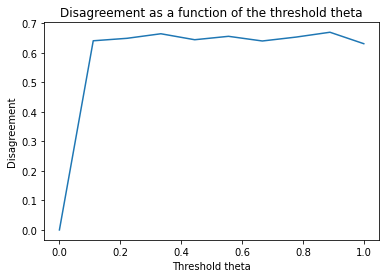

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

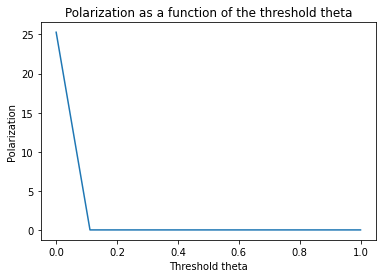

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

# Preprocessing Datasets

## Who-trust-whom Bitcoin platform: directed, weight represents trust, normalized to [-1, 1]

In [13]:
import csv
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-bitcoinotc.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        source = int(row[0])
        target = int(row[1])
        rating = float(row[2])

        # Normalize the rating to (0, 1]
        normalized_rating = rating / 10.0

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=normalized_rating)

In [15]:
print(G.number_of_nodes())
print(G.number_of_edges())

5881
35592


## Opinion review website with who-trust-whom, weights are either -1 or 1

In [50]:
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-epinions.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        source, target, sign = parts
        source = int(source)
        target = int(target)
        weight = int(sign)  # Should be either 1 or -1

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=weight)

In [51]:
print(G.number_of_nodes())
print(G.number_of_edges())

131825
841345


### EU research institution email communication, weights either 0 or 1. People who wrote at least one email have an edge with weight 1 in between. Also people from same department are assumed to know each other (has an edge in between).

In [53]:
import networkx as nx
from itertools import combinations

# Initialize an undirected graph
G = nx.Graph()

group_file = 'dataset/email-EU/email-EU-core-department-labels.txt'
group_dict = {}

with open(group_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        node_id, group_id = parts
        node_id = int(node_id)
        group_id = int(group_id)
        G.add_node(node_id)
        if group_id not in group_dict:
            group_dict[group_id] = []
        group_dict[group_id].append(node_id)

# Add edges between all nodes in the same group
for group_nodes in group_dict.values():
    for u, v in combinations(group_nodes, 2):
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

edge_file = 'dataset/email-EU/email-EU-core.txt'
with open(edge_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        u, v = parts
        u = int(u)
        v = int(v)
        G.add_node(u)
        G.add_node(v)
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

for u, v, data in G.edges(data=True):
    assert data['weight'] == 1, f"Edge ({u}, {v}) has incorrect weight {data['weight']}"

In [54]:
print(G.number_of_nodes())
print(G.number_of_edges())

1005
34857


## Visualize the graph G (without opinion assigned yet)

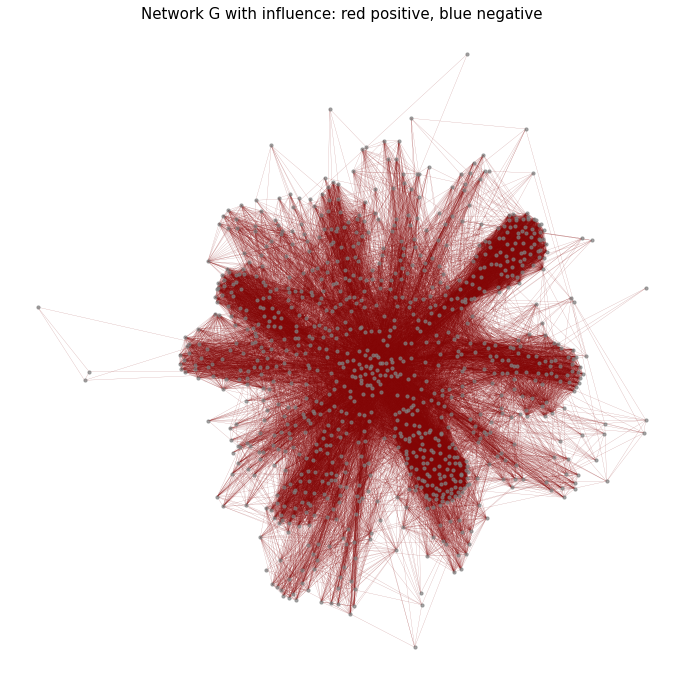

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

# Create a color map
cmap = plt.cm.seismic  # Blue for negative, white for neutral, red for positive
norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cmap(norm(w)) for w in weights]

node_size = 10
edge_width = 0.2

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='grey', alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_width, alpha=0.5, arrowsize=5)

plt.axis('off')
plt.title('Network G with influence: red positive, blue negative', fontsize=15)
plt.show()

## Now choose a graph G generated from one of the dataset. Compute the converged expressed opinion with threshold model.

In [57]:
import numpy as np
import networkx as nx
from scipy.stats import uniform
from scipy.special import expit

class SelfDefinedGraphFJ:
    def __init__(self, graph, internal_lower, internal_upper, model_type="normal", theta=None):
        self.graph = graph
        self.node_list = list(graph.nodes())
        self.node_to_index = {node: idx for idx, node in enumerate(self.node_list)}
        self.index_to_node = {idx: node for idx, node in enumerate(self.node_list)}
        self.n = len(self.node_list)
        
        # Initialize weights matrix (allowing negative weights)
        self.weights = np.zeros((self.n, self.n))
        for u, v, data in graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            self.weights[i, j] = data['weight']
        np.fill_diagonal(self.weights, 0)
        
        self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=self.n)
        self.expressed = self.internal.copy()
        
        self.model_type = model_type
        self.theta = theta if theta is not None else 0.5  # Default theta
    
    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'
    
    def disagreement(self):
        disagreement = 0
        for u, v, data in self.graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            weight = abs(self.weights[i, j])
            disagreement += weight * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement
    
    def polarization(self):
        avg_expressed = np.mean(self.expressed)
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)
    
    def update_weights(self):
        if self.model_type == "normal":
            pass
        elif self.model_type == "threshold":
            for u, v in self.graph.edges():
                i = self.node_to_index[u]
                j = self.node_to_index[v]
                if abs(self.expressed[i] - self.expressed[j]) >= self.theta:
                    self.weights[i, j] /= 2
        else:
            raise ValueError(f"Unknown model_type '{self.model_type}'. Supported types: 'normal', 'threshold'.")
    
    def run_one_step(self):
        total_influence = self.internal + self.weights @ self.expressed
        self.expressed = expit(total_influence)
        self.update_weights()
    
    def run_t_steps(self, t):
        for _ in range(t):
            self.run_one_step()

In [58]:
def get_disagreement_polarization(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    for _ in range(num_trials):
        G_model = model()
        G_model.run_t_steps(num_steps)
        disagreements.append(G_model.disagreement())
        polarizations.append(G_model.polarization())
    return np.mean(disagreements), np.mean(polarizations)

In [59]:
# Instantiate the model
model = lambda: SelfDefinedGraphFJ(graph=G, internal_lower=0, internal_upper=1, model_type="threshold", theta = 0.03)
avg_disagreement, avg_polarization = get_disagreement_polarization(model, num_steps=1000, num_trials=2)
print(f"Average Disagreement: {avg_disagreement}")
print(f"Average Polarization: {avg_polarization}")

Average Disagreement: 0.04644385769709636
Average Polarization: 5.372139626139345


In [61]:
expressed_opinions = model().expressed

### Visualization of the final graph with expressed opinion

In [64]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import numpy as np

def plot_graph_with_opinions(model):
    # Choose a colormap suitable for values in [0, 1]
    model = model()
    expressed_opinions = model.expressed
    G = model.graph
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    node_colors = [expressed_opinions[model.node_to_index[node]] for node in G.nodes()]
    node_colors_mapped = [cmap(norm(opinion)) for opinion in node_colors]
    
    pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)
    node_size = 50
    edge_width = 0.1
    
    # Plot the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=node_colors,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_width,
        edge_color='grey',
        alpha=0.3,
        arrowsize=5
    )
    
    plt.axis('off')
    plt.title('Graph of Expressed Opinions', fontsize=15)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Expressed Opinion', rotation=270, labelpad=15)  
    plt.show()

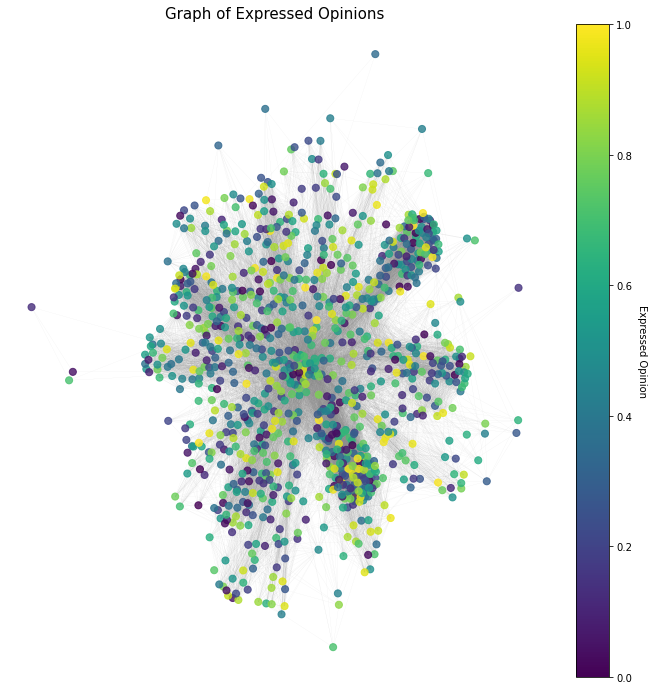

In [66]:
plot_graph_with_opinions(model)

# Trash (To be cleaned)

### Negative weight FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[-1,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d. Using sigmoid function to normalize

In [5]:
from scipy.special import expit

In [6]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs(loc=-1, scale=2)
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = expit(internal_opinions[i] + sum_neighboring_expressed_opinion)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [8]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

(np.float64(8809.911938472003), np.float64(58.37903571281214))

### Same setup, but with weight halving threshold model with uniform threshold $\theta_{ij} = \theta$

In [189]:
import networkx as nx
def run_fj_and_return_expressed_opinions(theta):
    # n = 300
    n = 10
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] /= 2
    T = 1000
    # T = 2
    for t in range(T):

        # print('-' * 50)
        # print('Before update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()
            
        update_weights()
        # print('After update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

G, expressed_opinions = run_fj_and_return_expressed_opinions(theta=0.01)
for i, nbrs in G.adj.items():
    for j, eattr in nbrs.items():
        print(i, j, round(eattr['weight'], 5), end=';\t')
    print()

# average_disagreements = []
# average_polarizations = []
# thetas = np.linspace(0,1,num=10)
# for theta in thetas:
#     average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
#     average_disagreements.append(average_disagreement)
#     average_polarizations.append(average_polarization)

0 1 0.0;	0 2 0.0;	0 3 0.0;	0 4 0.0;	0 6 0.0;	0 9 0.0;	
1 0 0.0;	1 2 0.0;	1 5 0.0;	1 6 0.0;	1 9 0.0;	
2 0 0.0;	2 1 0.0;	2 3 0.0;	2 4 0.0;	2 5 0.0;	2 6 0.0;	2 7 0.15995;	2 8 0.0;	2 9 0.0;	
3 0 0.0;	3 2 0.0;	3 4 0.0;	3 5 0.0;	3 7 0.0;	3 9 0.0;	
4 0 0.0;	4 2 0.0;	4 3 0.0;	4 6 0.0;	4 7 0.0;	
5 1 0.0;	5 2 0.0;	5 3 0.0;	5 6 0.0;	5 7 0.0;	5 8 0.0;	
6 0 0.0;	6 1 0.0;	6 2 0.0;	6 4 0.0;	6 5 0.0;	6 7 0.0;	6 9 0.0;	
7 2 0.15995;	7 3 0.0;	7 4 0.0;	7 5 0.0;	7 6 0.0;	7 8 0.0;	7 9 0.0;	
8 2 0.0;	8 5 0.0;	8 7 0.0;	
9 0 0.0;	9 1 0.0;	9 2 0.0;	9 3 0.0;	9 6 0.0;	9 7 0.0;	


In [178]:
import matplotlib.pyplot as plt

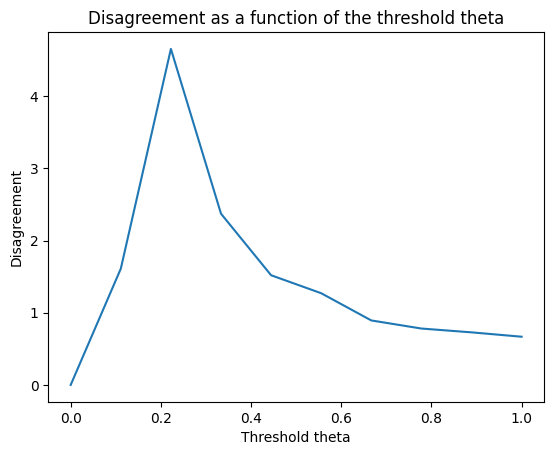

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

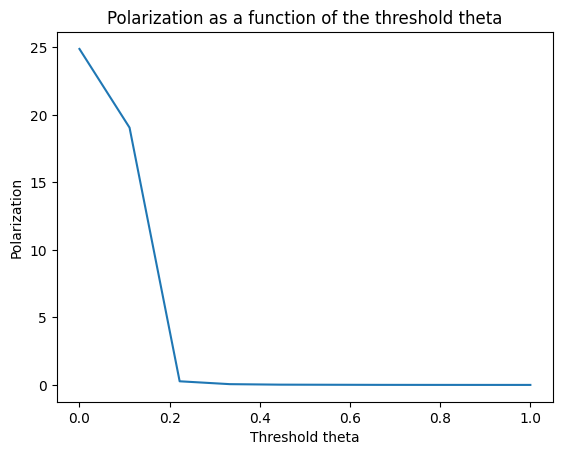

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

### Same thing, but weight increasing by $\delta = 1/10$

In [31]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    delta = 1/10
    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

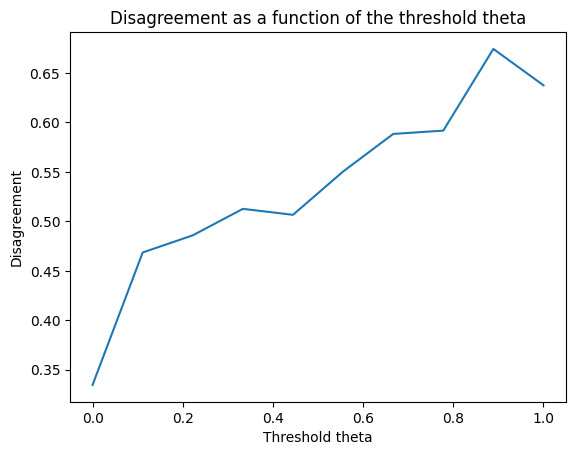

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_increase_weight_disagreement.png')

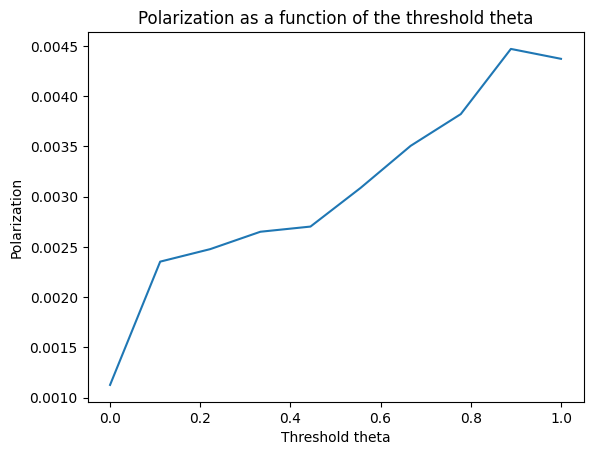

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_increase_weight_polarization.png')

### Same thing but using the probabilistic model

In [34]:
from scipy.stats import bernoulli

In [ ]:
def run_fj_and_return_expressed_opinions(delta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                coin_flip = bernoulli.rvs(abs(expressed_opinions[i] - expressed_opinions[j]))
                if not coin_flip:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
                else:
                    eattr['weight'] = max(eattr['weight'] - delta, 0)
                    
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_delta(delta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(delta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
deltas = np.linspace(0,0.5,num=10)
for delta in deltas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_delta(delta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the difference delta')
ax.plot(deltas, average_disagreements)
fig.savefig('probabilistic_model_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the difference delta')
ax.plot(deltas, average_polarizations)
fig.savefig('probabilistic_model_polarization.png')